In [1]:
import pandas as pd
import numpy as np
import six
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

df_lines = pd.read_csv("TheOfficeLinesPerCharacter.csv")
df_rating = pd.read_csv("TheOfficeIMDBPerEpisode.csv")

#Set up my master table
df_master = pd.DataFrame(columns = ["season", "episode", "rating"])
characters = df_lines.speaker.value_counts().reset_index(name="count").query("count > 100")["index"]

#Set up season, episode, and rating
episode = 1
season = 1
for i in range(len(df_rating.index)):
    if(season != df_rating.iloc[i]['Season']):
        episode = 1
        season += 1 
    df_master = df_master.append({'season': season, 'episode': episode, 'rating':df_rating.iloc[i]['Rating']}, ignore_index=True)
    episode += 1
      
#Add characters columns
for character in characters:
    df_master[str(character)] = np.NaN
    
#Add lines spoken count for each character
for j in range(len(df_lines.index)):
    speaker = df_lines.iloc[j]['speaker']
    if speaker in df_master.columns:
        season = df_lines.iloc[j]['season']
        episode = df_lines.iloc[j]['episode']
        index = df_master.loc[df_master['season']==season].loc[df_master['episode']==episode].index.values.astype(int)[0]
        if(pd.isna(df_master.at[index,speaker])):
            df_master.at[index,speaker] = 1
        else:
            df_master.at[index,speaker] += 1
    
#Clean up David's data
David_Wallace = df_master['David'] + df_master['David Wallace']
df_master['David'] = David_Wallace
df_master = df_master.drop(columns=['David Wallace'])

In [2]:
#Remove character that appeared in less than 30 episodes
TF = (df_master.isnull())

for col in TF.columns:
        if (TF[col].value_counts()[0] < 30):
            df_master = df_master.drop(columns=[col])
df_master.head()

season  episode  rating  Michael  Dwight   Jim   Pam  Andy  Kevin  Angela  \
0     1.0      1.0     7.5     97.0    35.0  37.0  46.0   NaN    2.0     5.0   
1     1.0      2.0     8.3    103.0    40.0  35.0  26.0   NaN    8.0     4.0   
2     1.0      3.0     7.8     69.0    88.0  57.0  44.0   NaN    6.0     5.0   
3     1.0      4.0     8.1    111.0    74.0  63.0  37.0   NaN    3.0     9.0   
4     1.0      5.0     8.4    134.0    45.0  27.0  17.0   NaN    4.0     6.0   

   ...  Phyllis  Kelly   Jan  Toby  Stanley  Meredith  Nellie  Creed  Gabe  \
0  ...      2.0    NaN  12.0   NaN      5.0       NaN     NaN    NaN   NaN   
1  ...      NaN    2.0   NaN   2.0      5.0       NaN     NaN    NaN   NaN   
2  ...      NaN    NaN  18.0   NaN      6.0       3.0     NaN    NaN   NaN   
3  ...      5.0    NaN   NaN   7.0      2.0      15.0     NaN    NaN   NaN   
4  ...      4.0    NaN   NaN   NaN      6.0       NaN     NaN    NaN   NaN   

    Roy  
0   5.0  
1   NaN  
2   NaN  
3   3.0  
4  13.0  

[5 rows x 24 columns]

Min:6.6
Mean:8.248404255319146
Max:9.8
Std:0.5787203349443079


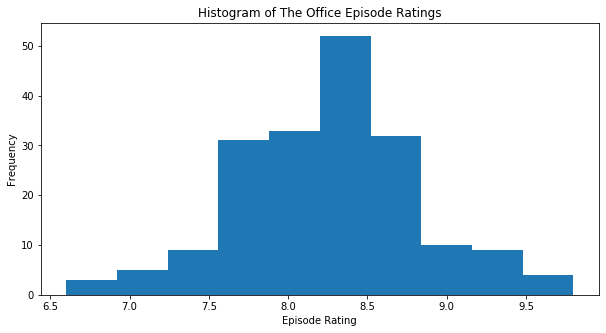

In [3]:
import pylab as pl
hist = df_master.hist(column = "rating", sharex=True, sharey=True, figsize=(10,5), grid=False)
pl.title("Histogram of The Office Episode Ratings")
pl.ylabel("Frequency")
pl.xlabel("Episode Rating")

print('Min:' + str(df_master['rating'].min()))
print('Mean:' + str(df_master['rating'].mean()))
print('Max:' + str(df_master['rating'].max()))
print('Std:' + str(df_master['rating'].std()))

In [4]:
#This class was found on stack overflow and simply renders images of my dataframes.
#I am not responsible for this code

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#3b3b3b', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

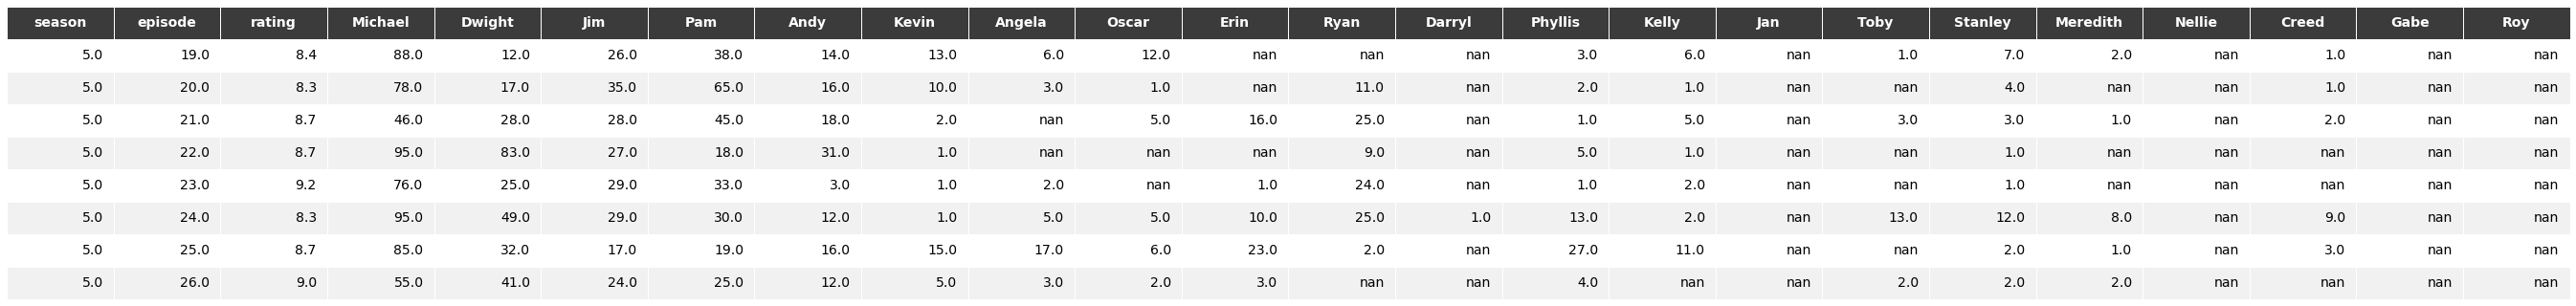

In [5]:
season5 = df_master.loc[df_master['season'] == 5.0]

pd.set_option('display.max_columns', None)
render_mpl_table(season5.iloc[18:26], header_columns=0, col_width=2.0)



In [6]:
#Create a second more condense dataset
df_condensed = pd.DataFrame(columns = ["character", "total lines", "avg lines per appearance"])

total_line = df_master.sum(axis=0)
for k in range(3, df_master.shape[1]):
    character = df_master.columns[k]
    total_appearence = len(df_master[character].loc[df_master[character] != 0])
    
    row = {"character" : character, "total lines" : int(total_line[k]), "avg lines per appearance" : int(total_line[k]/total_appearence)}
    df_condensed = df_condensed.append(row, ignore_index=True)

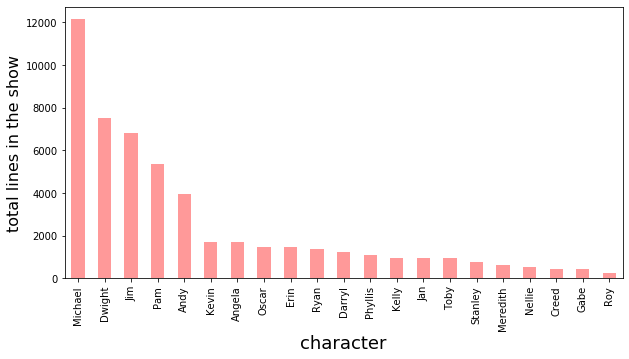

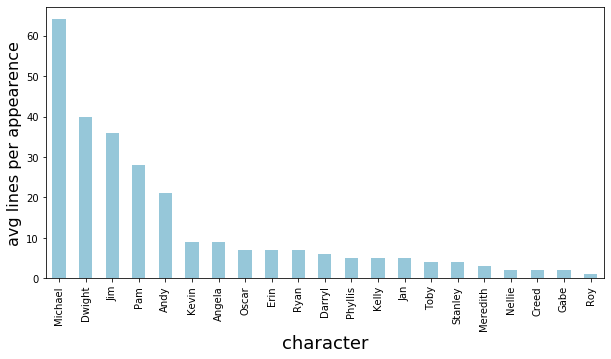

In [7]:
#Graph the current data
df_condensed.plot(x ='character', y='total lines', kind = 'bar', color='#ff9999', figsize=(10,5), legend=None)
plt.xlabel('character', fontsize=18)
plt.ylabel('total lines in the show', fontsize=16)
plt.show()

df_condensed.plot(x ='character', y='avg lines per appearance', kind = 'bar', color='#96c7d9', figsize=(10,5), legend=None)
plt.xlabel('character', fontsize=18)
plt.ylabel('avg lines per appearence', fontsize=16)
plt.show()

#characters = df_condensed.sort_values(by='total lines', ascending=False)['character'].astype(str).values.tolist()
#df_master.reset_index().plot(x='index', y = characters[:5], kind='line', figsize=(70,30))
#plt.show()

#df_master.reset_index().plot(x='index', y = ["Jim", "Dwight", "Pam"], kind='line', figsize=(70,30))
#plt.show()

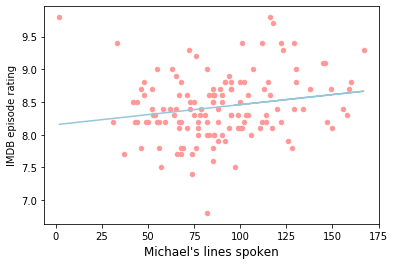

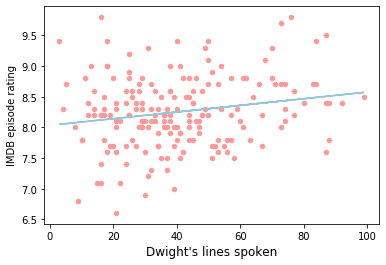

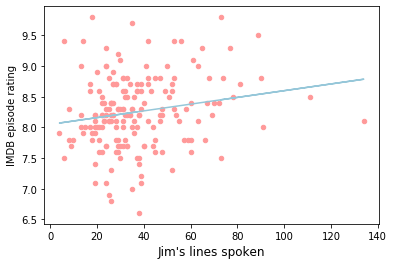

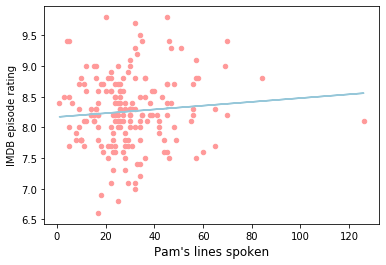

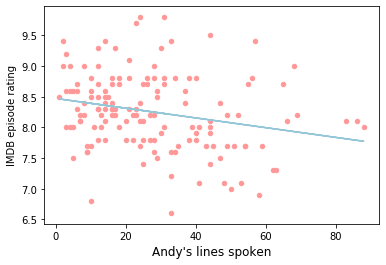

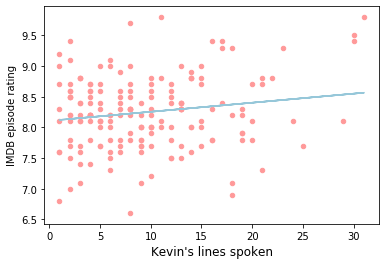

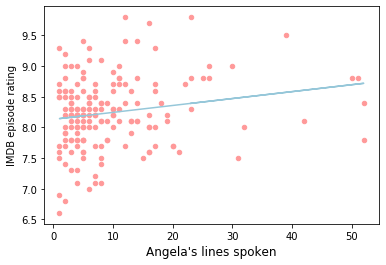

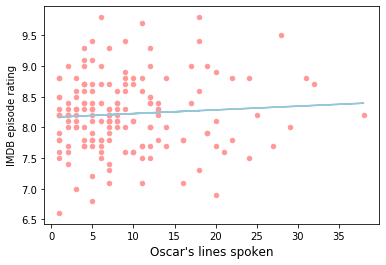

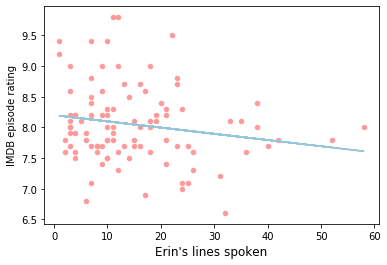

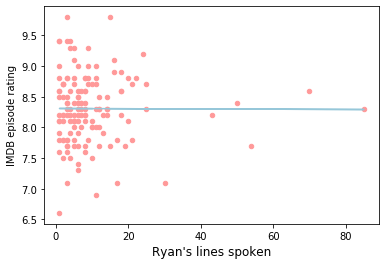

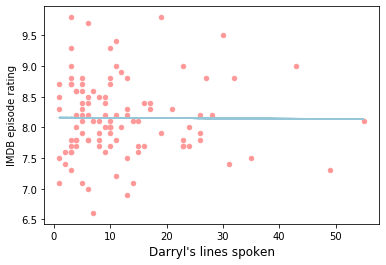

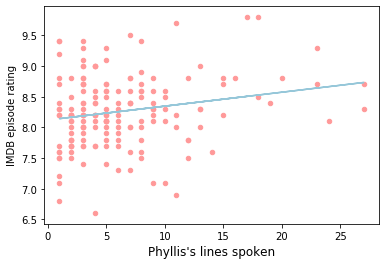

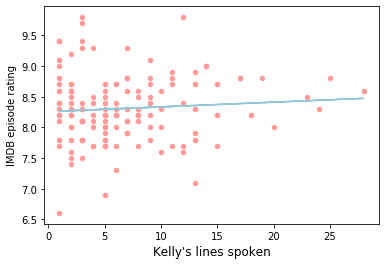

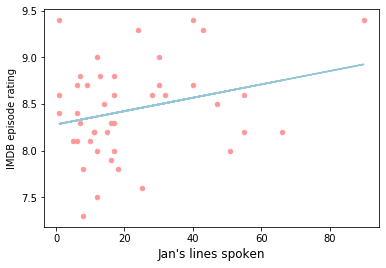

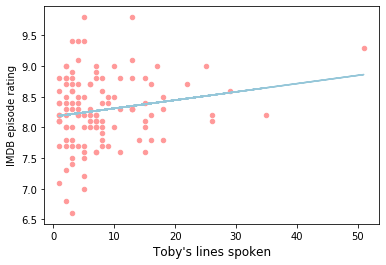

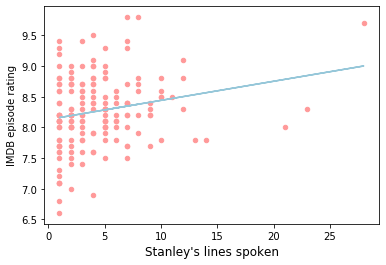

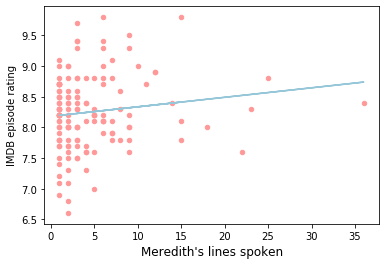

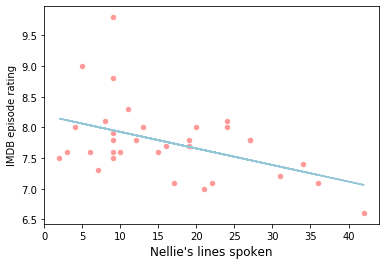

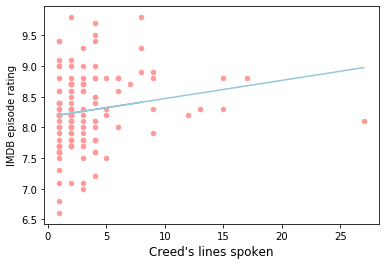

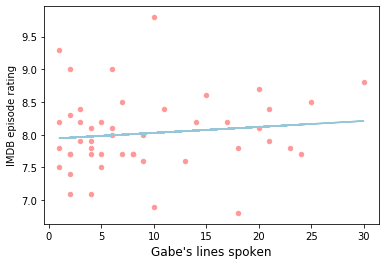

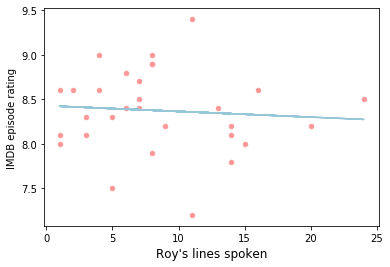

In [8]:
import random
#Calculate correlation between a given character's line count and the episode rating

cor = []

for char in df_condensed['character']:
    character = char
    
    cor.append( round(df_master['rating'].corr(df_master[char]),4) )
    
    df = df_master[['rating',character]].dropna()
    x = df[character].to_numpy()
    y = df['rating'].to_numpy()
    dem = x.dot(x) - x.mean() * x.sum()
    m = (x.dot(y) - y.mean() * x.sum())/dem
    b = (y.mean() * x.dot(x) - x.mean() * x.dot(y))/dem
    line = m*x + b

    df_master.plot(x = character, y='rating', kind = 'scatter', color='#ff9999', legend=None)
    plt.plot(x, line, '#96c7d9')
    plt.xlabel(character + "'s lines spoken", fontsize=12)
    plt.ylabel("IMDB episode rating")
    plt.show()

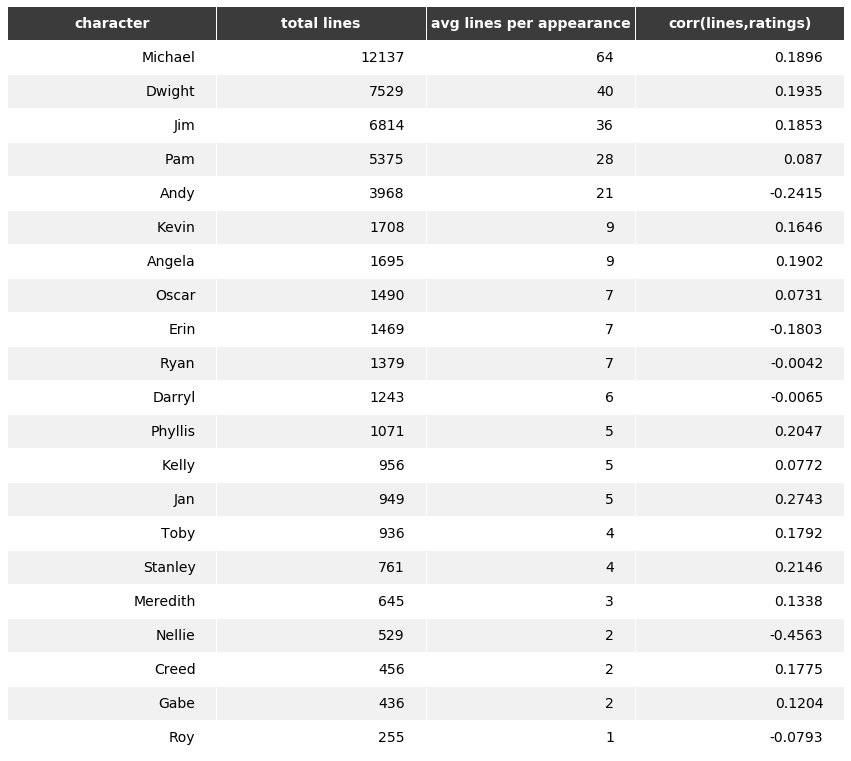

In [9]:
df_condensed["corr(lines,ratings)"] = cor
render_mpl_table(df_condensed, header_columns=0, col_width=3.75)

Michael Min:2.0
Michael Mean:88.5912408759124
Michael Max:167.0
Michael Std:30.849862890467918
Dwight Min:3.0
Dwight Mean:40.47849462365591
Dwight Max:99.0
Dwight Std:20.725544230913176


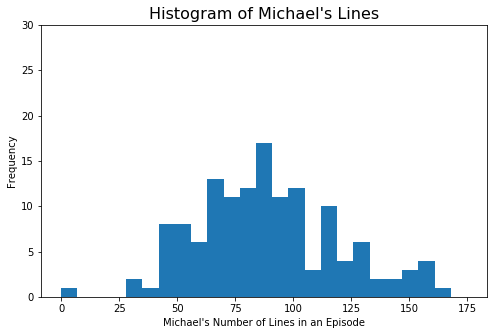

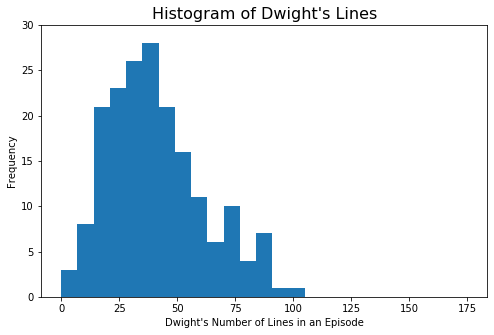

In [34]:
hist = df_master.hist(column = "Michael", sharex=True, sharey=True, figsize=(8,5), grid=False, bins=25, range=[0,175])
pl.ylim(0,30)
pl.title("Histogram of Michael's Lines", fontsize=16)
pl.ylabel("Frequency")
pl.xlabel("Michael's Number of Lines in an Episode")
print('Michael Min:' + str(df_master['Michael'].min()))
print('Michael Mean:' + str(df_master['Michael'].mean()))
print('Michael Max:' + str(df_master['Michael'].max()))
print('Michael Std:' + str(df_master['Michael'].std()))



hist = df_master.hist(column = "Dwight", sharex=True, sharey=True, figsize=(8,5), grid=False, bins=25, range=[0,175])
pl.ylim(0,30)
pl.title("Histogram of Dwight's Lines", fontsize=16)
pl.ylabel("Frequency")
pl.xlabel("Dwight's Number of Lines in an Episode")
print('Dwight Min:' + str(df_master['Dwight'].min()))
print('Dwight Mean:' + str(df_master['Dwight'].mean()))
print('Dwight Max:' + str(df_master['Dwight'].max()))
print('Dwight Std:' + str(df_master['Dwight'].std()))